# Tolerance analysis of simple 1.5D model, automatic dictionary construction, crude monte carlo, optimizaiton on epistemic space of uncertainty.

In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import scipy
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi, sqrt
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output, HTML, IFrame
from time import time, sleep
from sympy.printing import latex
from trimesh import viewer as trview
from scipy.optimize import OptimizeResult, minimize, Bounds, LinearConstraint, shgo, basinhopping, direct, dual_annealing

import otaf
from efficient_kan import KAN, KANLinear

notebook_name = os.path.splitext(os.path.basename(os.environ.get("JPY_SESSION_NAME")))[0]

In [2]:
### Different measures of our problem
X1 = 99.8   # Nominal Length of the male piece
X2 = 100.0  # Nominal Length of the female piece
X3 = 10.0   # Nominal height of the pieces
t = 0.2*sqrt(2)    # Tolerance for X1 and X2. (95% conform)  (= t/2)

## Coordinates, points, feature definitions.

In [3]:
# Global coordinate system
R0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

# Important points
# Pièce 1 (male)
P1A0, P1A1, P1A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P1B0, P1B1, P1B2 = (
    np.array((X1, X3 / 2, 0.0)),
    np.array((X1, X3, 0.0)),
    np.array((X1, 0, 0.0)),
)
P1C0, P1C1, P1C2 = (
    np.array((X1 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X1, 0, 0.0)),
)

# Pièce 2 (femelle)  # On met les points à hM et pas hF pour qu'ils soient bien opposées! (Besoin??)
P2A0, P2A1, P2A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P2B0, P2B1, P2B2 = (
    np.array((X2, X3 / 2, 0.0)),
    np.array((X2, X3, 0.0)),
    np.array((X2, 0, 0.0)),
)
P2C0, P2C1, P2C2 = (
    np.array((X2 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X2, 0, 0.0)),
)

# Local coordinate systems
# Pièce1
RP1a = np.array([-1 * x_, -1 * y_, z_])
RP1b = R0
RP1c = np.array([-y_, x_, z_])

# Pièce2
RP2a = R0
RP2b = np.array([-1 * x_, -1 * y_, z_])
RP2c = np.array([y_, -1 * x_, z_])

### Construction of the augmented system data dictionary.

In [4]:
system_data = {
    "PARTS" : {
        '1' : {
            "a" : {
                "FRAME": RP1a,
                "POINTS": {'A0' : P1A0, 'A1' : P1A1, 'A2' : P1A2},
                "TYPE": "plane",
                "INTERACTIONS": ['P2a'],
                "CONSTRAINTS_D": ["PERFECT"], # In this modelization, only defects on the right side
                "CONSTRAINTS_G": ["FLOATING"],            
            },
            "b" : {
                "FRAME": RP1b,
                "POINTS": {'B0' : P1B0, 'B1' : P1B1, 'B2' : P1B2},
                "TYPE": "plane",
                "INTERACTIONS": ['P2b'],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],            
            },
            "c" : {
                "FRAME": RP1c,
                "POINTS": {'C0' : P1C0, 'C1' : P1C1, 'C2' : P1C2},
                "TYPE": "plane",
                "INTERACTIONS": ['P2c'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            },
        },
        '2' : {
            "a" : {
                "FRAME": RP2a,
                "POINTS": {'A0' : P2A0, 'A1' : P2A1, 'A2' : P2A2},
                "TYPE": "plane",
                "INTERACTIONS": ['P1a'],
                "CONSTRAINTS_D": ["PERFECT"], # In this modelization, only defects on the right side
                "CONSTRAINTS_G": ["FLOATING"],            
            },
            "b" : {
                "FRAME": RP2b,
                "POINTS": {'B0' : P2B0, 'B1' : P2B1, 'B2' : P2B2},
                "TYPE": "plane",
                "INTERACTIONS": ['P1b'],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],            
            },
            "c" : {
                "FRAME": RP2c,
                "POINTS": {'C0' : P2C0, 'C1' : P2C1, 'C2' : P2C2},
                "TYPE": "plane",
                "INTERACTIONS": ['P1c'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            },
        }  
    },
    "LOOPS": {
        "COMPATIBILITY": {
            "L0": "P1cC0 -> P2cC0 -> P2aA0 -> P1aA0",
            "L1": "P1cC0 -> P2cC0 -> P2bB0 -> P1bB0",
        },
    },
    "GLOBAL_CONSTRAINTS": "2D_NZ",
}

In [5]:
SDA = otaf.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [6]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [7]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=20)
interface_constraints = ILH.get_interface_loop_expressions()

Processing part 2, surface a for plane-to-plane interactions.
usedGMatDat [['2', 'a', 'A0', '1', 'a', 'A0']]
Found 1 used gap matrices.
unusedGMatDat [['2', 'a', 'A2', '1', 'a', 'A2'], ['2', 'a', 'A1', '1', 'a', 'A1']]
Found 2 unused gap matrices.
Generated 2 interaction matrix loops for current matching.
Processing part 2, surface b for plane-to-plane interactions.
usedGMatDat [['2', 'b', 'B0', '1', 'b', 'B0']]
Found 1 used gap matrices.
unusedGMatDat [['2', 'b', 'B2', '1', 'b', 'B2'], ['2', 'b', 'B1', '1', 'b', 'B1']]
Found 2 unused gap matrices.
Generated 2 interaction matrix loops for current matching.


In [8]:
SOCAM = otaf.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

SOCAM.embedOptimizationVariable()

print(len(SOCAM.deviation_symbols), SOCAM.deviation_symbols)

4 [u_d_4, gamma_d_4, u_d_5, gamma_d_5]


## Construction of the stochastic model of the defects. (old lambda approach)

In [9]:
Cm = 1.0
sigma_e_pos = t / (6 * Cm)

# Le défaut en orientation est piloté par une incertitude sur un angle. On suppose les angles petits << 1 rad
theta_max = t / X3
sigma_e_theta = (2*theta_max) / (6*Cm) 

In [10]:
RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})

cons, linearConstraint = otaf.optimization.lambda_constraint_dict_from_composed_distribution(RandDeviationVect, )
bounds_lambda = otaf.optimization.bounds_from_composed_distribution(RandDeviationVect)

## Construction of a neural network based surrogate 
(could be omitted but makes things faster)

In [11]:
# Define the seed, sample size, and file paths
SEED = 420  # Example seed value
sample_size = 100000
model_name = notebook_name
sample_filename = f'STORAGE/training_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/training_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        TRAIN_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        TRAIN_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.15) # We now work with low failure probabilities
    #TRAIN_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size))
    TRAIN_SAMPLE = np.array(dist.getSample(sample_size),dtype="float32")
    # Compute the results
    TRAIN_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        SOCAM,
        TRAIN_SAMPLE,
        bounds=None,
        n_cpu=-2,
        progress_bar=True,
        batch_size=500,
        dtype="float32"
    )
    #TRAIN_RESULTS = np.array([res.x[-1] for res in TRAIN_RESULTS],dtype="float32") #Only s variable.
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, TRAIN_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, TRAIN_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from TRAIN_SAMPLE and TRAIN_RESULTS
Xtrain = TRAIN_SAMPLE
ytrain = TRAIN_RESULTS
print(f"Ratio of failed simulations in sample : {np.where(ytrain[:,-1]<0,1,0).sum()/sample_size}")

Loaded existing sample and results from file.
Ratio of failed simulations in sample : 0.0646


[4, 22, 12, 5, 1]


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 001, Val Loss: 0.934163, Val R2: -379.488434


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 002, Val Loss: 0.808545, Val R2: -53.502048


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 003, Val Loss: 0.634606, Val R2: -10.054356


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 004, Val Loss: 0.420897, Val R2: -1.319446


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 005, Val Loss: 0.232300, Val R2: 0.532521


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 006, Val Loss: 0.210292, Val R2: 0.812822


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 007, Val Loss: 0.273528, Val R2: 0.821968


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 008, Val Loss: 0.202238, Val R2: 0.850025


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 009, Val Loss: 0.128792, Val R2: 0.870313


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 010, Val Loss: 0.112255, Val R2: 0.846292


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 011, Val Loss: 0.116793, Val R2: 0.805487


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 012, Val Loss: 0.110151, Val R2: 0.808372


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 013, Val Loss: 0.087337, Val R2: 0.861415


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 014, Val Loss: 0.059478, Val R2: 0.921218


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 015, Val Loss: 0.041163, Val R2: 0.955695


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 016, Val Loss: 0.037485, Val R2: 0.965910


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 017, Val Loss: 0.039071, Val R2: 0.967155


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 018, Val Loss: 0.034266, Val R2: 0.970542


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 019, Val Loss: 0.026036, Val R2: 0.975453


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 020, Val Loss: 0.024787, Val R2: 0.973962


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 021, Val Loss: 0.028426, Val R2: 0.967863


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 022, Val Loss: 0.028839, Val R2: 0.967008


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 023, Val Loss: 0.025377, Val R2: 0.972253


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 024, Val Loss: 0.022271, Val R2: 0.977373


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 025, Val Loss: 0.021330, Val R2: 0.979667


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 026, Val Loss: 0.021024, Val R2: 0.980459


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 027, Val Loss: 0.019455, Val R2: 0.981558


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 028, Val Loss: 0.017350, Val R2: 0.982744


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 029, Val Loss: 0.016688, Val R2: 0.982586


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 030, Val Loss: 0.016796, Val R2: 0.982041


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 031, Val Loss: 0.016086, Val R2: 0.982930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 032, Val Loss: 0.015032, Val R2: 0.984530


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 033, Val Loss: 0.014523, Val R2: 0.985546


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 034, Val Loss: 0.014134, Val R2: 0.986176


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 035, Val Loss: 0.013486, Val R2: 0.986744


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 036, Val Loss: 0.012777, Val R2: 0.987199


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 037, Val Loss: 0.012214, Val R2: 0.987540


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 038, Val Loss: 0.011800, Val R2: 0.987895


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 039, Val Loss: 0.011288, Val R2: 0.988518


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 040, Val Loss: 0.010700, Val R2: 0.989280


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 041, Val Loss: 0.010259, Val R2: 0.989843


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 042, Val Loss: 0.009829, Val R2: 0.990290


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 043, Val Loss: 0.009328, Val R2: 0.990721


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 044, Val Loss: 0.008884, Val R2: 0.991075


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 045, Val Loss: 0.008478, Val R2: 0.991434


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 046, Val Loss: 0.008062, Val R2: 0.991873


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 047, Val Loss: 0.007652, Val R2: 0.992344


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 048, Val Loss: 0.007275, Val R2: 0.992767


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 049, Val Loss: 0.006928, Val R2: 0.993115


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 050, Val Loss: 0.006594, Val R2: 0.993413


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 051, Val Loss: 0.006282, Val R2: 0.993693


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 052, Val Loss: 0.005988, Val R2: 0.993990


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 053, Val Loss: 0.005712, Val R2: 0.994290


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 054, Val Loss: 0.005457, Val R2: 0.994564


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 055, Val Loss: 0.005222, Val R2: 0.994798


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 056, Val Loss: 0.005014, Val R2: 0.994995


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 057, Val Loss: 0.004822, Val R2: 0.995181


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 058, Val Loss: 0.004643, Val R2: 0.995362


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 059, Val Loss: 0.004479, Val R2: 0.995531


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 060, Val Loss: 0.004329, Val R2: 0.995683


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 061, Val Loss: 0.004189, Val R2: 0.995822


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 062, Val Loss: 0.004062, Val R2: 0.995948


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 063, Val Loss: 0.003946, Val R2: 0.996062


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 064, Val Loss: 0.003837, Val R2: 0.996171


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 065, Val Loss: 0.003736, Val R2: 0.996274


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 066, Val Loss: 0.003641, Val R2: 0.996371


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 067, Val Loss: 0.003553, Val R2: 0.996459


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 068, Val Loss: 0.003470, Val R2: 0.996540


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 069, Val Loss: 0.003392, Val R2: 0.996617


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 070, Val Loss: 0.003317, Val R2: 0.996695


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 071, Val Loss: 0.003246, Val R2: 0.996767


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 072, Val Loss: 0.003178, Val R2: 0.996834


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 073, Val Loss: 0.003113, Val R2: 0.996897


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 074, Val Loss: 0.003050, Val R2: 0.996960


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 075, Val Loss: 0.002989, Val R2: 0.997022


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 076, Val Loss: 0.002931, Val R2: 0.997081


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 077, Val Loss: 0.002874, Val R2: 0.997137


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 078, Val Loss: 0.002819, Val R2: 0.997191


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 079, Val Loss: 0.002766, Val R2: 0.997244


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 080, Val Loss: 0.002714, Val R2: 0.997296


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 081, Val Loss: 0.002662, Val R2: 0.997348


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 082, Val Loss: 0.002613, Val R2: 0.997398


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 083, Val Loss: 0.002564, Val R2: 0.997446


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 084, Val Loss: 0.002516, Val R2: 0.997493


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 085, Val Loss: 0.002469, Val R2: 0.997540


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 086, Val Loss: 0.002423, Val R2: 0.997586


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 087, Val Loss: 0.002378, Val R2: 0.997631


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 088, Val Loss: 0.002334, Val R2: 0.997675


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 089, Val Loss: 0.002291, Val R2: 0.997718


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 090, Val Loss: 0.002249, Val R2: 0.997760


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 091, Val Loss: 0.002207, Val R2: 0.997802


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 092, Val Loss: 0.002166, Val R2: 0.997843


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 093, Val Loss: 0.002126, Val R2: 0.997883


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 094, Val Loss: 0.002087, Val R2: 0.997922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 095, Val Loss: 0.002049, Val R2: 0.997960


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 096, Val Loss: 0.002011, Val R2: 0.997998


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 097, Val Loss: 0.001973, Val R2: 0.998035


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 098, Val Loss: 0.001937, Val R2: 0.998071


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 099, Val Loss: 0.001901, Val R2: 0.998107


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 100, Val Loss: 0.001866, Val R2: 0.998142


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 101, Val Loss: 0.001832, Val R2: 0.998176


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 102, Val Loss: 0.001798, Val R2: 0.998210


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 103, Val Loss: 0.001765, Val R2: 0.998243


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 104, Val Loss: 0.001732, Val R2: 0.998275


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 105, Val Loss: 0.001700, Val R2: 0.998307


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 106, Val Loss: 0.001669, Val R2: 0.998338


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 107, Val Loss: 0.001639, Val R2: 0.998369


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 108, Val Loss: 0.001609, Val R2: 0.998399


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 109, Val Loss: 0.001579, Val R2: 0.998428


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 110, Val Loss: 0.001550, Val R2: 0.998457


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 111, Val Loss: 0.001522, Val R2: 0.998485


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 112, Val Loss: 0.001494, Val R2: 0.998513


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 113, Val Loss: 0.001467, Val R2: 0.998540


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 114, Val Loss: 0.001440, Val R2: 0.998566


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 115, Val Loss: 0.001414, Val R2: 0.998592


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 116, Val Loss: 0.001389, Val R2: 0.998618


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 117, Val Loss: 0.001364, Val R2: 0.998643


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 118, Val Loss: 0.001339, Val R2: 0.998668


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 119, Val Loss: 0.001315, Val R2: 0.998692


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 120, Val Loss: 0.001291, Val R2: 0.998715


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 121, Val Loss: 0.001268, Val R2: 0.998738


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 122, Val Loss: 0.001245, Val R2: 0.998761


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 123, Val Loss: 0.001223, Val R2: 0.998783


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 124, Val Loss: 0.001201, Val R2: 0.998805


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 125, Val Loss: 0.001180, Val R2: 0.998826


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 126, Val Loss: 0.001159, Val R2: 0.998847


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 127, Val Loss: 0.001138, Val R2: 0.998868


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 128, Val Loss: 0.001118, Val R2: 0.998888


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 129, Val Loss: 0.001098, Val R2: 0.998908


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 130, Val Loss: 0.001079, Val R2: 0.998927


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 131, Val Loss: 0.001060, Val R2: 0.998946


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 132, Val Loss: 0.001041, Val R2: 0.998965


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 133, Val Loss: 0.001022, Val R2: 0.998983


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 134, Val Loss: 0.001004, Val R2: 0.999001


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 135, Val Loss: 0.000986, Val R2: 0.999019


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 136, Val Loss: 0.000969, Val R2: 0.999037


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 137, Val Loss: 0.000952, Val R2: 0.999054


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 138, Val Loss: 0.000935, Val R2: 0.999071


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 139, Val Loss: 0.000918, Val R2: 0.999087


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 140, Val Loss: 0.000902, Val R2: 0.999103


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 141, Val Loss: 0.000886, Val R2: 0.999119


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 142, Val Loss: 0.000870, Val R2: 0.999135


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 143, Val Loss: 0.000854, Val R2: 0.999151


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 144, Val Loss: 0.000839, Val R2: 0.999166


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 145, Val Loss: 0.000824, Val R2: 0.999181


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 146, Val Loss: 0.000809, Val R2: 0.999196


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 147, Val Loss: 0.000795, Val R2: 0.999210


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 148, Val Loss: 0.000780, Val R2: 0.999224


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 149, Val Loss: 0.000766, Val R2: 0.999238


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 150, Val Loss: 0.000753, Val R2: 0.999252


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 151, Val Loss: 0.000739, Val R2: 0.999265


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 152, Val Loss: 0.000726, Val R2: 0.999279


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 153, Val Loss: 0.000713, Val R2: 0.999292


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 154, Val Loss: 0.000700, Val R2: 0.999304


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 155, Val Loss: 0.000687, Val R2: 0.999317


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 156, Val Loss: 0.000675, Val R2: 0.999329


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 157, Val Loss: 0.000663, Val R2: 0.999341


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 158, Val Loss: 0.000651, Val R2: 0.999353


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 159, Val Loss: 0.000639, Val R2: 0.999365


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 160, Val Loss: 0.000628, Val R2: 0.999376


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 161, Val Loss: 0.000616, Val R2: 0.999387


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 162, Val Loss: 0.000605, Val R2: 0.999398


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 163, Val Loss: 0.000595, Val R2: 0.999409


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 164, Val Loss: 0.000584, Val R2: 0.999420


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 165, Val Loss: 0.000574, Val R2: 0.999430


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 166, Val Loss: 0.000563, Val R2: 0.999440


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 167, Val Loss: 0.000553, Val R2: 0.999450


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 168, Val Loss: 0.000544, Val R2: 0.999460


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 169, Val Loss: 0.000534, Val R2: 0.999469


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 170, Val Loss: 0.000525, Val R2: 0.999479


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 171, Val Loss: 0.000515, Val R2: 0.999488


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 172, Val Loss: 0.000506, Val R2: 0.999497


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 173, Val Loss: 0.000498, Val R2: 0.999506


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 174, Val Loss: 0.000489, Val R2: 0.999514


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 175, Val Loss: 0.000481, Val R2: 0.999523


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 176, Val Loss: 0.000472, Val R2: 0.999531


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 177, Val Loss: 0.000464, Val R2: 0.999539


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 178, Val Loss: 0.000456, Val R2: 0.999547


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 179, Val Loss: 0.000449, Val R2: 0.999554


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 180, Val Loss: 0.000441, Val R2: 0.999562


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 181, Val Loss: 0.000434, Val R2: 0.999569


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 182, Val Loss: 0.000426, Val R2: 0.999577


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 183, Val Loss: 0.000419, Val R2: 0.999584


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 184, Val Loss: 0.000412, Val R2: 0.999591


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 185, Val Loss: 0.000405, Val R2: 0.999597


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 186, Val Loss: 0.000399, Val R2: 0.999604


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 187, Val Loss: 0.000392, Val R2: 0.999610


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 188, Val Loss: 0.000386, Val R2: 0.999617


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 189, Val Loss: 0.000380, Val R2: 0.999623


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 190, Val Loss: 0.000374, Val R2: 0.999629


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 191, Val Loss: 0.000368, Val R2: 0.999635


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 192, Val Loss: 0.000362, Val R2: 0.999641


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 193, Val Loss: 0.000356, Val R2: 0.999646


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 194, Val Loss: 0.000350, Val R2: 0.999652


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 195, Val Loss: 0.000345, Val R2: 0.999657


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 196, Val Loss: 0.000340, Val R2: 0.999663


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 197, Val Loss: 0.000334, Val R2: 0.999668


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 198, Val Loss: 0.000329, Val R2: 0.999673


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 199, Val Loss: 0.000324, Val R2: 0.999678


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 200, Val Loss: 0.000320, Val R2: 0.999683


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 201, Val Loss: 0.000315, Val R2: 0.999687


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 202, Val Loss: 0.000310, Val R2: 0.999692


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 203, Val Loss: 0.000306, Val R2: 0.999697


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 204, Val Loss: 0.000301, Val R2: 0.999701


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 205, Val Loss: 0.000297, Val R2: 0.999705


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 206, Val Loss: 0.000293, Val R2: 0.999709


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 207, Val Loss: 0.000288, Val R2: 0.999714


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 208, Val Loss: 0.000284, Val R2: 0.999718


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 209, Val Loss: 0.000280, Val R2: 0.999722


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 210, Val Loss: 0.000277, Val R2: 0.999725


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 211, Val Loss: 0.000273, Val R2: 0.999729


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 212, Val Loss: 0.000269, Val R2: 0.999733


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 213, Val Loss: 0.000265, Val R2: 0.999736


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 214, Val Loss: 0.000262, Val R2: 0.999740


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 215, Val Loss: 0.000258, Val R2: 0.999743


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 216, Val Loss: 0.000255, Val R2: 0.999747


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 217, Val Loss: 0.000252, Val R2: 0.999750


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 218, Val Loss: 0.000249, Val R2: 0.999753


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 219, Val Loss: 0.000245, Val R2: 0.999756


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 220, Val Loss: 0.000242, Val R2: 0.999759


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 221, Val Loss: 0.000239, Val R2: 0.999762


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 222, Val Loss: 0.000236, Val R2: 0.999765


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 223, Val Loss: 0.000234, Val R2: 0.999768


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 224, Val Loss: 0.000231, Val R2: 0.999771


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 225, Val Loss: 0.000228, Val R2: 0.999774


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 226, Val Loss: 0.000225, Val R2: 0.999776


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 227, Val Loss: 0.000223, Val R2: 0.999779


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 228, Val Loss: 0.000220, Val R2: 0.999781


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 229, Val Loss: 0.000218, Val R2: 0.999784


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 230, Val Loss: 0.000215, Val R2: 0.999786


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 231, Val Loss: 0.000213, Val R2: 0.999789


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 232, Val Loss: 0.000210, Val R2: 0.999791


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 233, Val Loss: 0.000208, Val R2: 0.999793


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 234, Val Loss: 0.000206, Val R2: 0.999796


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 235, Val Loss: 0.000204, Val R2: 0.999798


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 236, Val Loss: 0.000202, Val R2: 0.999800


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 237, Val Loss: 0.000199, Val R2: 0.999802


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 238, Val Loss: 0.000197, Val R2: 0.999804


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 239, Val Loss: 0.000195, Val R2: 0.999806


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 240, Val Loss: 0.000193, Val R2: 0.999808


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 241, Val Loss: 0.000191, Val R2: 0.999810


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 242, Val Loss: 0.000190, Val R2: 0.999812


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 243, Val Loss: 0.000188, Val R2: 0.999814


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 244, Val Loss: 0.000186, Val R2: 0.999816


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 245, Val Loss: 0.000184, Val R2: 0.999817


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 246, Val Loss: 0.000182, Val R2: 0.999819


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 247, Val Loss: 0.000181, Val R2: 0.999821


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 248, Val Loss: 0.000179, Val R2: 0.999822


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 249, Val Loss: 0.000177, Val R2: 0.999824


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 250, Val Loss: 0.000176, Val R2: 0.999826


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 251, Val Loss: 0.000174, Val R2: 0.999827


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 252, Val Loss: 0.000172, Val R2: 0.999829


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 253, Val Loss: 0.000171, Val R2: 0.999830


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 254, Val Loss: 0.000169, Val R2: 0.999832


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 255, Val Loss: 0.000168, Val R2: 0.999833


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 256, Val Loss: 0.000166, Val R2: 0.999835


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 257, Val Loss: 0.000165, Val R2: 0.999836


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 258, Val Loss: 0.000163, Val R2: 0.999838


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 259, Val Loss: 0.000162, Val R2: 0.999839


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 260, Val Loss: 0.000161, Val R2: 0.999840


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 261, Val Loss: 0.000159, Val R2: 0.999842


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 262, Val Loss: 0.000158, Val R2: 0.999843


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 263, Val Loss: 0.000157, Val R2: 0.999844


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 264, Val Loss: 0.000155, Val R2: 0.999846


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 265, Val Loss: 0.000154, Val R2: 0.999847


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 266, Val Loss: 0.000153, Val R2: 0.999848


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 267, Val Loss: 0.000152, Val R2: 0.999849


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 268, Val Loss: 0.000150, Val R2: 0.999851


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 269, Val Loss: 0.000149, Val R2: 0.999852


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 270, Val Loss: 0.000148, Val R2: 0.999853


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 271, Val Loss: 0.000147, Val R2: 0.999854


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 272, Val Loss: 0.000146, Val R2: 0.999855


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 273, Val Loss: 0.000145, Val R2: 0.999856


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 274, Val Loss: 0.000144, Val R2: 0.999857


  0%|          | 0/2 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 352, Val Loss: 0.000092, Val R2: 0.999908


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 353, Val Loss: 0.000092, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 354, Val Loss: 0.000091, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 355, Val Loss: 0.000091, Val R2: 0.999910


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 356, Val Loss: 0.000091, Val R2: 0.999910


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 357, Val Loss: 0.000090, Val R2: 0.999910


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 358, Val Loss: 0.000090, Val R2: 0.999911


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 359, Val Loss: 0.000089, Val R2: 0.999911


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 360, Val Loss: 0.000089, Val R2: 0.999912


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 361, Val Loss: 0.000089, Val R2: 0.999912


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 362, Val Loss: 0.000089, Val R2: 0.999911


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 363, Val Loss: 0.000091, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 364, Val Loss: 0.000098, Val R2: 0.999903


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 365, Val Loss: 0.000112, Val R2: 0.999889


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 366, Val Loss: 0.000116, Val R2: 0.999885


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 367, Val Loss: 0.000091, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 368, Val Loss: 0.000091, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 369, Val Loss: 0.000100, Val R2: 0.999901


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 370, Val Loss: 0.000087, Val R2: 0.999914


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 371, Val Loss: 0.000091, Val R2: 0.999910


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 372, Val Loss: 0.000091, Val R2: 0.999909


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 373, Val Loss: 0.000085, Val R2: 0.999916


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 374, Val Loss: 0.000089, Val R2: 0.999912


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 375, Val Loss: 0.000086, Val R2: 0.999915


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 376, Val Loss: 0.000085, Val R2: 0.999916


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 377, Val Loss: 0.000086, Val R2: 0.999914


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 378, Val Loss: 0.000083, Val R2: 0.999917


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 379, Val Loss: 0.000084, Val R2: 0.999917


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 380, Val Loss: 0.000084, Val R2: 0.999917


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 381, Val Loss: 0.000082, Val R2: 0.999918


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 382, Val Loss: 0.000083, Val R2: 0.999918


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 383, Val Loss: 0.000082, Val R2: 0.999918


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 384, Val Loss: 0.000081, Val R2: 0.999919


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 385, Val Loss: 0.000082, Val R2: 0.999919


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 386, Val Loss: 0.000081, Val R2: 0.999920


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 387, Val Loss: 0.000080, Val R2: 0.999920


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 388, Val Loss: 0.000081, Val R2: 0.999920


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 389, Val Loss: 0.000080, Val R2: 0.999920


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 390, Val Loss: 0.000080, Val R2: 0.999921


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 391, Val Loss: 0.000079, Val R2: 0.999921


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 392, Val Loss: 0.000079, Val R2: 0.999921


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 393, Val Loss: 0.000079, Val R2: 0.999922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 394, Val Loss: 0.000078, Val R2: 0.999922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 395, Val Loss: 0.000078, Val R2: 0.999922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 396, Val Loss: 0.000078, Val R2: 0.999923


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 397, Val Loss: 0.000078, Val R2: 0.999923


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 398, Val Loss: 0.000077, Val R2: 0.999923


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 399, Val Loss: 0.000077, Val R2: 0.999923


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 400, Val Loss: 0.000077, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 401, Val Loss: 0.000077, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 402, Val Loss: 0.000076, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 403, Val Loss: 0.000076, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 404, Val Loss: 0.000076, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 405, Val Loss: 0.000076, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 406, Val Loss: 0.000076, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 407, Val Loss: 0.000075, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 408, Val Loss: 0.000075, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 409, Val Loss: 0.000075, Val R2: 0.999926


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 410, Val Loss: 0.000075, Val R2: 0.999926


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 411, Val Loss: 0.000075, Val R2: 0.999926


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 412, Val Loss: 0.000075, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 413, Val Loss: 0.000076, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 414, Val Loss: 0.000077, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 415, Val Loss: 0.000078, Val R2: 0.999922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 416, Val Loss: 0.000081, Val R2: 0.999920


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 417, Val Loss: 0.000083, Val R2: 0.999918


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 418, Val Loss: 0.000081, Val R2: 0.999919


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 419, Val Loss: 0.000077, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 420, Val Loss: 0.000073, Val R2: 0.999928


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 421, Val Loss: 0.000072, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 422, Val Loss: 0.000073, Val R2: 0.999927


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 423, Val Loss: 0.000074, Val R2: 0.999927


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 424, Val Loss: 0.000073, Val R2: 0.999927


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 425, Val Loss: 0.000072, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 426, Val Loss: 0.000071, Val R2: 0.999930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 427, Val Loss: 0.000070, Val R2: 0.999930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 428, Val Loss: 0.000071, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 429, Val Loss: 0.000072, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 430, Val Loss: 0.000072, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 431, Val Loss: 0.000071, Val R2: 0.999929


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 432, Val Loss: 0.000071, Val R2: 0.999930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 433, Val Loss: 0.000070, Val R2: 0.999930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 434, Val Loss: 0.000069, Val R2: 0.999931


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 435, Val Loss: 0.000069, Val R2: 0.999932


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 436, Val Loss: 0.000069, Val R2: 0.999932


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 437, Val Loss: 0.000068, Val R2: 0.999932


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 438, Val Loss: 0.000068, Val R2: 0.999933


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 439, Val Loss: 0.000068, Val R2: 0.999933


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 440, Val Loss: 0.000068, Val R2: 0.999933


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 441, Val Loss: 0.000068, Val R2: 0.999933


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 442, Val Loss: 0.000068, Val R2: 0.999932


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 443, Val Loss: 0.000069, Val R2: 0.999931


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 444, Val Loss: 0.000072, Val R2: 0.999928


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 445, Val Loss: 0.000078, Val R2: 0.999922


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 446, Val Loss: 0.000088, Val R2: 0.999912


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 447, Val Loss: 0.000094, Val R2: 0.999907


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 448, Val Loss: 0.000081, Val R2: 0.999919


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 449, Val Loss: 0.000066, Val R2: 0.999934


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 450, Val Loss: 0.000070, Val R2: 0.999930


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 451, Val Loss: 0.000077, Val R2: 0.999924


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 452, Val Loss: 0.000070, Val R2: 0.999931


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 453, Val Loss: 0.000065, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 454, Val Loss: 0.000069, Val R2: 0.999931


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 455, Val Loss: 0.000069, Val R2: 0.999931


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 456, Val Loss: 0.000065, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 457, Val Loss: 0.000065, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 458, Val Loss: 0.000067, Val R2: 0.999934


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 459, Val Loss: 0.000065, Val R2: 0.999935


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 460, Val Loss: 0.000064, Val R2: 0.999937


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 461, Val Loss: 0.000064, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 462, Val Loss: 0.000065, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 463, Val Loss: 0.000064, Val R2: 0.999937


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 464, Val Loss: 0.000063, Val R2: 0.999938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 465, Val Loss: 0.000063, Val R2: 0.999938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 466, Val Loss: 0.000063, Val R2: 0.999937


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 467, Val Loss: 0.000063, Val R2: 0.999938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 468, Val Loss: 0.000062, Val R2: 0.999938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 469, Val Loss: 0.000062, Val R2: 0.999939


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 470, Val Loss: 0.000062, Val R2: 0.999938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 471, Val Loss: 0.000062, Val R2: 0.999939


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 472, Val Loss: 0.000062, Val R2: 0.999939


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 473, Val Loss: 0.000061, Val R2: 0.999939


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 474, Val Loss: 0.000061, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 475, Val Loss: 0.000061, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 476, Val Loss: 0.000061, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 477, Val Loss: 0.000060, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 478, Val Loss: 0.000060, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 479, Val Loss: 0.000060, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 480, Val Loss: 0.000060, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 481, Val Loss: 0.000060, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 482, Val Loss: 0.000060, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 483, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 484, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 485, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 486, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 487, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 488, Val Loss: 0.000060, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 489, Val Loss: 0.000061, Val R2: 0.999939


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 490, Val Loss: 0.000065, Val R2: 0.999936


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 491, Val Loss: 0.000074, Val R2: 0.999927


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 492, Val Loss: 0.000090, Val R2: 0.999911


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 493, Val Loss: 0.000102, Val R2: 0.999898


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 494, Val Loss: 0.000083, Val R2: 0.999917


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 495, Val Loss: 0.000058, Val R2: 0.999942


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 496, Val Loss: 0.000068, Val R2: 0.999933


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 497, Val Loss: 0.000075, Val R2: 0.999925


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 498, Val Loss: 0.000061, Val R2: 0.999940


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 499, Val Loss: 0.000059, Val R2: 0.999941


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 500, Val Loss: 0.000066, Val R2: 0.999934
Finished training at epoch 500 with best loss 0.000058 and R2 of 0.999942


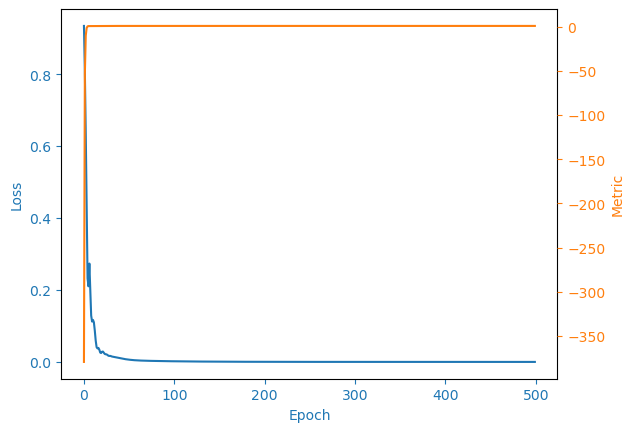

In [12]:
save_path = f'STORAGE/{notebook_name}.pth'
load = False
dim = int(RandDeviationVect.getDimension())
neural_model = otaf.surrogate.NeuralRegressorNetwork(
    dim, 1,
    Xtrain, ytrain[:,-1], 
    clamping=True, 
    finish_critertion_epoch=5,
    loss_finish=1e-6, 
    metric_finish=0.99999, 
    max_epochs=500, 
    batch_size=30000, 
    compile_model=False, 
    train_size=0.6, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=False)

lr=0.003

#neural_model.model = KAN([dim, 8, 4, 1])  #otaf.surrogate.get_base_relu_mlp_model(dim, 1, False)

neural_model.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([dim, 100, 70, 30, 1], activation_class=otaf.torch.nn.GELU)
)

neural_model.optimizer = otaf.torch.optim.AdamW(neural_model.parameters(), lr=lr, weight_decay=1e-4)
otaf.surrogate.initialize_model_weights(neural_model)
neural_model.scheduler =  otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model.optimizer, 1.0001)
neural_model.loss_fn = otaf.torch.nn.MSELoss()
#neural_model.loss_fn = otaf.uncertainty.LimitSpaceFocusedLoss(0.0001, 2, square=True) # otaf.uncertainty.PositiveLimitSpaceFocusedLoss(0.0001, 2, 4, square=False)

if os.path.exists(save_path) and load:
    neural_model.load_model()
else :
    neural_model.train_model()
    neural_model.plot_results()
    neural_model.save_model()

## Optimization on the imprecise space of defects, ot get upper and lower probability of failure given the constraints on the defect parameters.

In [13]:
# Threshold and scaling factors
scale_factor = 1  # Adjust this scaling factor for your specific range


N_SAMPLE_MINI = int(1e7)
standards = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if "sigma" in param] 
means = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if "mu" in param] 
sample = np.array(RandDeviationVect.getSample(N_SAMPLE_MINI))
threshold = 0

def model(x):
    gap_variable_array = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        SOCAM, x, n_cpu=-1, progress_bar=True
    )
    slack_variable = gap_variable_array[:, -1]
    return slack_variable

def model2(x): #Neural model
    return np.squeeze(neural_model.evaluate_model_non_standard_space(x).detach().numpy())

def optimization_function_mini(x, getJac=True, model=model2, scale_factor=scale_factor): 
    if getJac:
        res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
            threshold, sample, means, standards, model, model_is_bool=True)(x)
        # Scale both objective and Jacobian
        return res[0] * scale_factor, res[1] * scale_factor
    else:
        x = sample * np.sqrt(x[np.newaxis, :])
        return model(x).mean() * scale_factor  # Scale mean value

def optimization_function_maxi(x, getJac=True, model=model2, scale_factor=scale_factor): 
    if getJac:
        res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
            threshold, sample, means, standards, model, model_is_bool=True)(x)
        # Scale both objective and Jacobian, but remember this is maximization, so we multiply by -1
        return -1 * res[0] * scale_factor, -1 * res[1] * scale_factor
    else:
        x = sample * np.sqrt(x[np.newaxis, :])
        return -1 * model(x).mean() * scale_factor  # Scale mean value

# Define the callback function
def print_callback(xk):
    print(f"Current parameter values: {xk}")

In [14]:
res = minimize(optimization_function_maxi,[0.3, 0.7]*2, 
         jac=True, method="SLSQP", args=(True,),
         options={"disp":True, "maxiter":100, "ftol":1e-6, 'eps':0.1},      
         bounds=bounds_lambda, constraints=cons, callback=print_callback)

display(res)

Current parameter values: [0.30399148 0.69600852 0.30398808 0.69601192]
Current parameter values: [0.32400394 0.67599606 0.32398394 0.67601606]
Current parameter values: [0.42549163 0.57450837 0.42538953 0.57461047]
Current parameter values: [0.97506061 0.02493939 0.97452495 0.02547505]
Current parameter values: [1.00000000e+00 2.15105711e-16 1.00000000e+00 2.50147125e-15]
Current parameter values: [1.00000000e+00 2.15105711e-16 1.00000000e+00 2.50147125e-15]
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -0.09825191646814346
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: -0.09825191646814346
       x: [ 1.000e+00  2.151e-16  1.000e+00  2.501e-15]
     nit: 6
     jac: [ 2.080e-05  3.191e+10 -2.472e-05  1.009e+09]
    nfev: 6
    njev: 6

In [15]:
x0_maxi = [0.3, 0.7]*2 #[0.25]*RandDeviationVect.getDimension() # [0.1,0.1,0.4,0.4]*8  # Initial guess

res = minimize(optimization_function_maxi, x0_maxi, 
               method="COBYQA", jac=False, args=(False,), 
               bounds=bounds_lambda, 
               constraints=linearConstraint, 
               options={"f_target":-1.0, 
                        "maxiter":1000,
                        "maxfev":1500,
                        "feasibility_tol":1e-4,
                        "initial_tr_radius":1,
                        "final_tr_radius":1e-7,
                       "disp":True}, 
               callback = None) #print_callback

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 1e-07.
Maximum number of function evaluations: 1500.
Maximum number of iterations: 1000.

optimization_function_maxi([ 5.000e-01  5.000e-01  5.000e-01  5.000e-01]) = -0.08119651675224304
optimization_function_maxi([ 1.000e+00  5.000e-01  5.000e-01  5.000e-01]) = -0.08119616657495499
optimization_function_maxi([ 5.000e-01  1.000e+00  5.000e-01  5.000e-01]) = -0.07697094976902008
optimization_function_maxi([ 5.000e-01  5.000e-01  1.000e+00  5.000e-01]) = -0.0811978429555893
optimization_function_maxi([ 5.000e-01  5.000e-01  5.000e-01  1.000e+00]) = -0.07697293907403946
optimization_function_maxi([ 1.000e-24  5.000e-01  5.000e-01  5.000e-01]) = -0.08119425922632217
optimization_function_maxi([ 5.000e-01  1.000e-24  5.000e-01  5.000e-01]) = -0.08669313043355942
optimization_function_maxi([ 5.000e-01  5.000e-01  1.000e-24  5.000e-01]) = -0.08119641244411469
optimization_function_maxi([ 5.000e-0

In [16]:
res = minimize(optimization_function_mini,[1, 1, 1, 1], 
         jac=True, method="SLSQP", args=(True,),
         options={"disp":True, "maxiter":100, "ftol":1e-8, "eps":0.1},      
         bounds=bounds_lambda, constraints=cons, callback=print_callback)

display(res)

Current parameter values: [0.49667408 0.50332592 0.4966739  0.5033261 ]
Current parameter values: [0.49198184 0.50801816 0.49198109 0.50801891]
Current parameter values: [0.46862809 0.53137191 0.46862504 0.53137496]
Current parameter values: [0.35443001 0.64556999 0.35441832 0.64558168]


/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Current parameter values: [0.00000000e+00 1.00000000e+00 2.77555756e-16 1.00000000e+00]
Current parameter values: [0.00000000e+00 1.00000000e+00 2.77555756e-16 1.00000000e+00]
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.07340794801712036
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6


/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 0.07340794801712036
       x: [ 0.000e+00  1.000e+00  2.776e-16  1.000e+00]
     nit: 6
     jac: [ 1.564e+19 -6.633e-03  5.418e+10 -6.624e-03]
    nfev: 6
    njev: 6

In [17]:
epsilon = 1e-6

# Generate a grid of x[0] and x[2] values with an epsilon margin
x0_values = np.linspace(epsilon, 1 - epsilon, 100)
x2_values = np.linspace(epsilon, 1 - epsilon, 100)
x0_grid, x2_grid = np.meshgrid(x0_values, x2_values)

# Initialize arrays to store the function values and gradient norms
value_grid = np.zeros_like(x0_grid)
gradient_norm_grid = np.zeros_like(x0_grid)

# Evaluate the function and gradient norm at each grid point
for i in range(x0_grid.shape[0]):
    for j in range(x0_grid.shape[1]):
        x0 = x0_grid[i, j]
        x2 = x2_grid[i, j]
        x = [x0, 1-x0, x2, 1-x2]
        value, gradient = optimization_function_maxi(x)
        value_grid[i, j] = value
        gradient_norm_grid[i, j] = np.linalg.norm(gradient)

# Plotting the function values
plt.figure(figsize=(12, 6))

# Plot function values
plt.subplot(1, 2, 1)
plt.contourf(x0_grid, x2_grid, value_grid, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.xlabel('$x[0]$')
plt.ylabel('$x[2]$')
plt.title('Function Values')

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.contourf(x0_grid, x2_grid, gradient_norm_grid, levels=50, cmap='plasma')
plt.colorbar(label='Gradient Norm')
plt.xlabel('$x[0]$')
plt.ylabel('$x[2]$')
plt.title('Gradient Norms')

plt.tight_layout()
plt.show()

BeartypeCallHintParamViolation: Function otaf.uncertainty._reliability.intermediate_lambda_function() parameter lambdas=[1e-06, 0.999999, 1e-06, 0.999999] violates type hint <class 'numpy.ndarray'>, as list [1e-06, 0.999999, 1e-06, 0.999999] not instance of <protocol "numpy.ndarray">.

In [ ]:
# Plotting the function values
plt.figure(figsize=(12, 6))

# Plot function values
plt.subplot(1, 2, 1)
plt.contourf(x0_grid, x2_grid, value_grid/scale_factor, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.xlabel('$x[0]$')
plt.ylabel('$x[2]$')
plt.title('Function Values')

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.contourf(x0_grid, x2_grid, np.where(gradient_norm_grid/scale_factor>0.1,0.1,gradient_norm_grid/scale_factor), levels=60, cmap='plasma')
plt.colorbar(label='Gradient Norm')
plt.xlabel('$x[0]$')
plt.ylabel('$x[2]$')
plt.title('Gradient Norms')

plt.tight_layout()
plt.show()

In [ ]:
a'g

#### As you can see, the optimization is not capable of finding the minimum/maximum, due to the middle zone being flat. 

## Let's try global optimization !

In [ ]:
# Basinhopping for the maximization function
x0_maxi = [.5]*4  # Initial guess

minimizer_kwargs_maxi = {
    "method": "SLSQP",
    "args": (False,),
    "constraints": cons,
    "bounds": bounds_lambda,
    "options": {"disp": False, "maxiter": 100, "ftol": 1e-6, "eps":0.01}
}

res_maxi = basinhopping(optimization_function_maxi, x0_maxi, 
                        niter=80, 
                        T=5.5, 
                        stepsize=2.3, 
                        niter_success=19,
                        interval=15,
                        target_accept_rate=0.44,
                        stepwise_factor=0.73,                        
                        minimizer_kwargs=minimizer_kwargs_maxi, disp=True)


print("Maximization Result:")
print(res_maxi)

In [ ]:
# Basinhopping for the minimization function
x0_mini = [.5]*4  # Initial guess

minimizer_kwargs_mini = {
    "method": "SLSQP",
    "args": (False,),
    "constraints": cons,
    "bounds": bounds_lambda,
    "options": {"disp": True, "maxiter": 100, "ftol": 1e-8, "eps":0.001}
}

res_mini = basinhopping(optimization_function_mini, x0_mini,
                        niter=80, 
                        T=5.5, 
                        stepsize=2.3, 
                        niter_success=19,
                        interval=15,
                        target_accept_rate=0.44,
                        stepwise_factor=0.73,                        
                        minimizer_kwargs=minimizer_kwargs_maxi, disp=True)

print("Minimization Result:")
print(res_mini)

best_params_maxi

best_params_mini

### Results :

In [ ]:
results_array = np.array([[80.182,  1.276,  3.110, 19.326, 85.911, 0.445,  0.726],
[55.866,  1.695,  1.252, 97.917, 11.467, 0.510 ,  0.580],
[81.046,  7.024,  3.161, 52.917 , 22.954, 0.122,  0.564],
[57.059,  7.767,  2.544, 64.469, 16.478, 0.424,  0.887],
[77.686  ,  4.737,  1.854, 88.378, 13.230, 0.223,  0.892],
[177.175,   5.441,   4.900,  82.017 , 15.701,   0.710,   0.777],
[69.056,  3.553,  2.071, 29.702, 26.634 , 0.324,  0.957],
[100.007,   5.310,   1.037,  96.541, 20.207 ,   0.835,   0.982],
[55.337,  5.494,  0.848, 39.742, 23.283 , 0.279 ,  0.731],
[122.673,   4.215 ,   3.807,  38.694, 15.465,   0.339,   0.606],
[95.877,  5.579,  0.654, 66.933, 25.929, 0.406,  0.513],
[167.494,   8.662,   2.578 ,  63.197, 12.251,   0.830,   0.806],
[50.299,  6.270,  0.807, 53.847, 66.134, 0.449,  0.690],
[176.291,   5.938,   3.781,  52.256, 16.557,   0.728,   0.513]])

In [ ]:
data = results_array
# Extract bounds for normalization
bounds = np.array(list(param_bounds.values()))
min_bounds = bounds[:, 0]
max_bounds = bounds[:, 1]

# Normalize the data
normalized_data = (data - min_bounds) / (max_bounds - min_bounds)

# Calculate the median and IQR
median_normalized = np.median(normalized_data, axis=0)
q1_normalized = np.percentile(normalized_data, 25, axis=0)
q3_normalized = np.percentile(normalized_data, 75, axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

for i, row in enumerate(normalized_data):
    ax.plot(range(1, len(row) + 1), row, marker='o', label=f'Trajectory {i + 1}')

# Plot the median
ax.plot(range(1, len(median_normalized) + 1), median_normalized, color='black', linewidth=2, label='Median')

# Plot the IQR as a see-through gray area
ax.fill_between(range(1, len(median_normalized) + 1),
                q1_normalized,
                q3_normalized,
                color='gray', alpha=0.3, label='Interquartile Range')

# Set plot labels and title
ax.set_xlabel('Parameter Index')
ax.set_ylabel('Normalized Value')
ax.set_title('Normalized Parameter Trajectories from LHS Runs')
ax.set_xticks(range(1, len(param_bounds) + 1))
ax.set_xticklabels(param_bounds.keys(), rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
np.median(data,axis=0)